# Step 1. Exploratory Data Analysis

---

In this step, we are exploring our dataset by loading it using our custom `dataset.load()` function. The resulting dataframe consists of the following columns:

- **ImgPath**: Path to the image.
- **FileType**: The extension of the image file.
- **Width**: The width (in pixels) of the image.
- **Height**: The height (in pixels) of the image.
- **Ratio**: The aspect ratio of the image. Calculated by taking its Width divided by its Height.
- **Mode**: The mode of the image. Possible values: [Pillow docs](https://pillow.readthedocs.io/en/latest/handbook/concepts.html#concept-modes).
- **Bands**: A string containing all bands of this image, separated by a space character. Read more: [bands](https://pillow.readthedocs.io/en/latest/handbook/concepts.html#bands). Closely related to Mode.
- **Transparency**: Whether this image has transparency.
- **Animated**: Whether this image has more than one frame.
- **Class**: Type of flower in the image. Can be either one of our 8 flower types. **<span style="color:red">TARGET COLUMN</span>**

To detect duplicate images, we are comparing the `str` hash of each image calculated using the [imagehash](https://pypi.org/project/ImageHash/) library.

For an overview of the dataset, we are focusing on analyzing the following columns:

1. **FileType:** We are observing this to see how many different file formats there are in our dataset. These would need to be converted into a single format during data cleaning.
2. **Ratio:** From this, we will pick out the most common ratio for our images to be cropped into during data processing.
3. **Mode:** Related to transparency: There are only a few modes that support alpha channel necessary for transparency in an image.
4. **Transparency:** Machine learning algorithms does not play well with transparent images. We will need to process these.
5. **Animated:** Machine learning algorithms cannot process animated images (images with more than 1 frame). If we have such image in our dataset, we need to isolate and extract their individual frames.
6. **Class:** We are observing if our dataset is balanced or not, and if this column has the correct format for our Machine Learning models.

In [1]:
# Imports and environmental setups

import matplotlib.pyplot as plt
import imagehash
from PIL import Image


# Custom utils functions
from utils import dataset
from utils.visualization import data_countplot
from utils.visualization import data_histplot


plt.style.use('ggplot')

## Load Dataset

Using our custom `dataset.load()` function.

In [2]:
df_raw = dataset.load('../data/raw')

In [3]:
df_raw.describe()

,Width,Height,Ratio
count,16362.000000,16362.000000,16362.000000
mean,693.434360,692.961374,1.039756
std,550.176343,580.224863,0.303225
min,100.000000,100.000000,0.475460
25%,266.250000,260.000000,0.793478
50%,600.000000,546.500000,1.000000
75%,894.000000,850.000000,1.164596
max,5472.000000,5184.000000,3.317073


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16362 entries, 0 to 16361
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ImgPath       16362 non-null  object 
 1   FileType      16362 non-null  object 
 2   Width         16362 non-null  int64  
 3   Height        16362 non-null  int64  
 4   Ratio         16362 non-null  float64
 5   Mode          16362 non-null  object 
 6   Bands         16362 non-null  object 
 7   Transparency  16362 non-null  bool   
 8   Animated      16362 non-null  bool   
 9   Class         16362 non-null  object 
dtypes: bool(2), float64(1), int64(2), object(5)
memory usage: 1.0+ MB


In [5]:
df_raw.sample(n=42, random_state=42)

,ImgPath,FileType,Width,Height,Ratio,Mode,Bands,Transparency,Animated,Class
5379,Chrysanthemum/001293.jpg,jpg,1280,853,1.500586,RGB,R G B,False,False,Chrysanthemum
6176,Hydrangeas/000026.jpg,jpg,600,450,1.333333,RGB,R G B,False,False,Hydrangeas
10769,Pingpong/000481.jpg,jpg,1000,1333,0.750188,RGB,R G B,False,False,Pingpong
7593,Hydrangeas/001443.jpg,jpg,760,442,1.719457,RGB,R G B,False,False,Hydrangeas
10662,Pingpong/000374.jpg,jpg,600,749,0.801068,RGB,R G B,False,False,Pingpong
2087,Calimerio/000026.jpg,jpg,1024,768,1.333333,RGB,R G B,False,False,Calimerio
123,Baby/000124.jpg,jpg,800,1131,0.707339,RGB,R G B,False,False,Baby
8962,Lisianthus/000764.jpg,jpg,521,587,0.887564,RGB,R G B,False,False,Lisianthus
10010,Lisianthus/lisianthus_720.jpg,jpg,219,230,0.952174,RGB,R G B,False,False,Lisianthus
8419,Lisianthus/000221.jpg,jpg,750,1000,0.750000,RGB,R G B,False,False,Lisianthus


## 1.1. Duplicated Images

Method: Comparing `imagehash.average_hash()` of each image. Average Hash (aHash) is chosen over other hashing algorithms such as pHash, dHash, wHash... because it is the most computationally efficient while still providing a good result to accurately detect image duplication.

In [6]:
image_hashes = {}
duplicates_count = 0
for i, row in df_raw.iterrows():
    with Image.open(f'../data/raw/{row["ImgPath"]}') as im:
        image_hash = imagehash.average_hash(im, hash_size=8)
        if image_hash in image_hashes:
            image_hashes[image_hash].append(row["ImgPath"])
            duplicates_count += 1
        else:
            image_hashes[image_hash] = [row["ImgPath"]]

duplicated_image_hashes = {hash_val: paths for hash_val, paths in image_hashes.items() if len(paths) > 1}  # Remove hashes with a single path

In [7]:
print(f'Number of duplicated images: {duplicates_count}')

Number of duplicated images: 17


**Duplication Detection Accuracy:**

We are looking at three sample duplications from `duplicated_image_hashes` to check if they are indeed duplications or not:

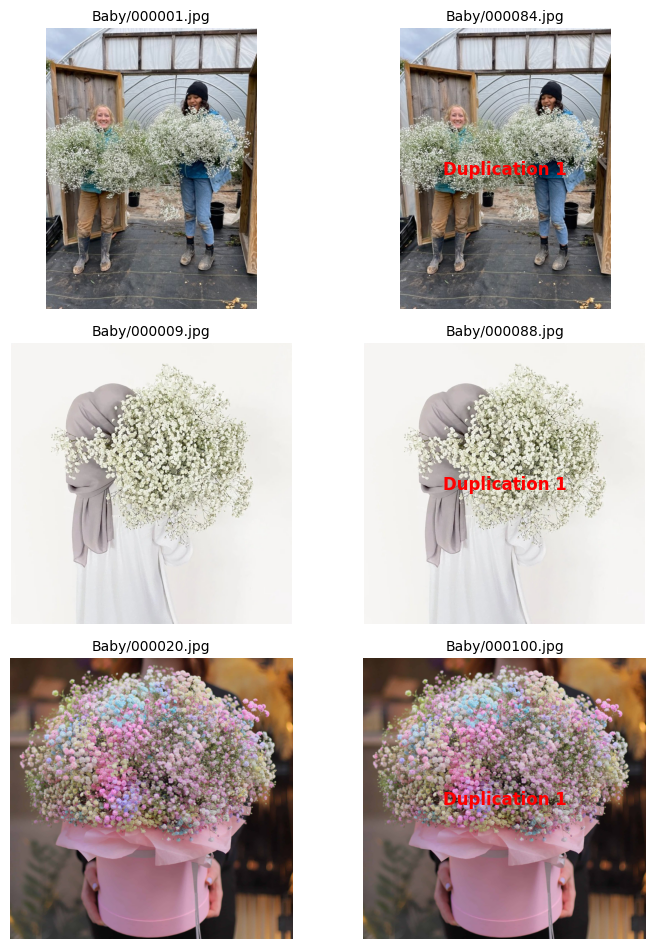

In [34]:
sample_indices = [0, len(duplicated_image_hashes.values()) // 2, len(duplicated_image_hashes.values()) - 1]

fig, ax = plt.subplots(
    3,
    max([
        len(list(duplicated_image_hashes.values())[sample_indices[0]]),
        len(list(duplicated_image_hashes.values())[sample_indices[1]]),
        len(list(duplicated_image_hashes.values())[sample_indices[2]])
    ]),
    figsize=(8, 8)
)

for iteration, sample_index in enumerate(sample_indices):
    paths = list(duplicated_image_hashes.values())[sample_index]
    for i, path in enumerate(paths):
        im = Image.open(f'../data/raw/{path}')
        ax[iteration, i].imshow(im)
        if i > 0:
            ax[iteration, i].text(
                0.5, 0.5, f'Duplication {i}',
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax[iteration, i].transAxes,
                fontsize=12,
                color='red',
                weight='bold'
            )
        ax[iteration, i].set_title(path, fontsize=10)
        ax[iteration, i].axis('off')

plt.subplots_adjust(wspace=-0.2, hspace=2)
fig.tight_layout(rect=[0, 0, 1.2, 1.2])
plt.show()

## 1.2. Dataset Overview

Columns of focus: FileType, Ratio, Mode, Transparency, Animated, and Class.

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

data_countplot(df_raw, 'FileType', ax=ax[0][0], title='File Types', annotate=True, palette='Set2')
data_histplot(df_raw, 'Ratio', ax=ax[0][1], title='Image Ratio Density', bins=20, kde=True, stat='density')
data_countplot(df_raw, 'Mode', ax=ax[0][2], title='Image Modes', annotate=True, palette='Accent')
data_countplot(df_raw, 'Transparency', ax=ax[1][0], title='Transparency', annotate=True, palette='YlGn')
data_countplot(df_raw, 'Animated', ax=ax[1][1], title='Animated', annotate=True, palette='YlGn')
data_countplot(df_raw, 'Class', ax=ax[1][2], horizontal=True, title='Flower Classes', xticklabels_rotation=45, annotate=True, palette='Set1')

fig.suptitle('Raw Dataset Statistics', fontsize=20, fontweight='bold', y=1.0)
fig.tight_layout()

fig.savefig('images/EDA-RawDataset-Stats.png')

## 1.3. ☞ Final Observation

---

### Duplicated Images:

There are a lot of duplications in our dataset. We need to keep only one copy for each of these duplications.

---

### Dataset Overview:

#### File Type:

The majority of our raw dataset images are `.jpg` files (non-transparent). This will be our file format of choice that all other formats will be converted to:

- `.jpeg`: These extensions can just be renamed to `.jpg`, since they are different extension standards for the same file format.
- `.png`: Conversion for this format to `jpg` would be more involved, since this format might contain an alpha channel for transparency.


#### Image Width, Height and Ratio:

Our images are of various different width and height, and the most common ratio of our raw dataset images is 1:1 (1.0). During data processing, all images of ratio different from this will be cropped and resized to match a common 1:1 dimensions to enhance our models' performance.

**Note:** Image ratio is calculated from an image's width divided by its height (see [`dataset.load()`](../utils/dataset.py) docs).

#### Mode and Transparency:

The majority of our raw dataset are non-transparent `RGB` images.

There are also 18 non-transparent 8-bit grayscale pixels images (`L` mode). These images will not work with our Machine Learning models at all, since we are working with colored images. Since their number is insignificant, we can safely exclude them from our dataset during processing without making our dataset unbalanced.

There are 323 images with transparency. Of these, there are 306 `RGBA` images. Thus, there must be 17 `P` images (8-bit colored pixels) with transparency, leaving us with 183 non-transparent `P` images. We will need to convert all of these into non-transparent `RGB` mode during data processing.


#### Animated Images:

We have no animated images in our dataset. No action needed.


#### Class <span style="color:red">(target column)</span>:

Our raw dataset is already class balanced with roughly 2000 samples per class. No action needed to balance them.

However, this column needs encoding for it to work with our Machine Learning models. We will use [Label Encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) for this column because:

- We have 8 classes. Using one-hot encoding would create too many columns, slowing down our code.
- We are dealing with Nominal categories (no inherent order).